In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma, 
               states, actions, next_states, dones, rates):
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=states.dtype)
    e_next_states_logits, eQlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size,
                                         action_size=action_size, state_size=state_size)
    ################################################ a = act(s)
    ################################################ s', r = env(s, a)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    a_next_states_logits, aQlogits = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    ###############################################
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                         axis=1))
    eloss += -tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                   labels=next_states_labels), 
                                           axis=1))
    aloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                          axis=1))
    #################################################### 
    eQlogits = tf.reshape(eQlogits, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits, labels=rates))
    ################################################ a = act(s)
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, nextQlogits = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                         action_size=action_size, state_size=state_size, reuse=True)
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.square(eQlogits - nextQlogits))
    ################################################################################ -log p(a/s) * gQ
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, labels=actions_labels)
    aQlogits = tf.reshape(aQlogits, shape=[-1])
    eloss += -tf.reduce_mean(neg_log_prob * aQlogits) # minQ/maxError
    aloss += tf.reduce_mean(neg_log_prob * aQlogits) # maxQ/minError
    return actions_logits, aloss, eloss

In [7]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, dones=self.dones, 
            rates=self.rates)
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:2.7338 eloss:0.8125 exploreP:0.9984
Episode:1 meanR:19.0000 R:22.0000 rate:0.0440 aloss:2.7418 eloss:0.8019 exploreP:0.9962
Episode:2 meanR:20.6667 R:24.0000 rate:0.0480 aloss:2.7389 eloss:0.8123 exploreP:0.9939
Episode:3 meanR:22.2500 R:27.0000 rate:0.0540 aloss:2.7361 eloss:0.8002 exploreP:0.9912
Episode:4 meanR:23.2000 R:27.0000 rate:0.0540 aloss:2.7322 eloss:0.7903 exploreP:0.9886
Episode:5 meanR:23.1667 R:23.0000 rate:0.0460 aloss:2.7280 eloss:0.7803 exploreP:0.9863
Episode:6 meanR:21.7143 R:13.0000 rate:0.0260 aloss:2.7265 eloss:0.7740 exploreP:0.9851
Episode:7 meanR:20.7500 R:14.0000 rate:0.0280 aloss:2.7120 eloss:0.7748 exploreP:0.9837
Episode:8 meanR:21.5556 R:28.0000 rate:0.0560 aloss:2.7216 eloss:0.7674 exploreP:0.9810
Episode:9 meanR:20.5000 R:11.0000 rate:0.0220 aloss:2.7087 eloss:0.7776 exploreP:0.9799
Episode:10 meanR:20.9091 R:25.0000 rate:0.0500 aloss:2.7137 eloss:0.7644 exploreP:0.9775
Episode:11 meanR:21.2500 R:25.0

Episode:93 meanR:22.7553 R:32.0000 rate:0.0640 aloss:3.8714 eloss:-0.0103 exploreP:0.8094
Episode:94 meanR:22.6632 R:14.0000 rate:0.0280 aloss:3.8552 eloss:0.0159 exploreP:0.8082
Episode:95 meanR:22.5729 R:14.0000 rate:0.0280 aloss:3.8644 eloss:0.0020 exploreP:0.8071
Episode:96 meanR:22.4742 R:13.0000 rate:0.0260 aloss:3.8484 eloss:0.0081 exploreP:0.8061
Episode:97 meanR:22.9184 R:66.0000 rate:0.1320 aloss:3.7690 eloss:0.1014 exploreP:0.8008
Episode:98 meanR:22.8485 R:16.0000 rate:0.0320 aloss:3.7509 eloss:0.1126 exploreP:0.7996
Episode:99 meanR:22.7900 R:17.0000 rate:0.0340 aloss:3.7274 eloss:0.1648 exploreP:0.7982
Episode:100 meanR:22.7600 R:13.0000 rate:0.0260 aloss:3.7162 eloss:0.1749 exploreP:0.7972
Episode:101 meanR:22.6500 R:11.0000 rate:0.0220 aloss:3.6746 eloss:0.1924 exploreP:0.7964
Episode:102 meanR:22.7900 R:38.0000 rate:0.0760 aloss:3.6239 eloss:0.2426 exploreP:0.7934
Episode:103 meanR:22.6900 R:17.0000 rate:0.0340 aloss:3.6570 eloss:0.2109 exploreP:0.7920
Episode:104 mean

Episode:185 meanR:18.1600 R:14.0000 rate:0.0280 aloss:3.2423 eloss:0.6111 exploreP:0.6901
Episode:186 meanR:17.9900 R:12.0000 rate:0.0240 aloss:3.2167 eloss:0.6034 exploreP:0.6893
Episode:187 meanR:17.9800 R:18.0000 rate:0.0360 aloss:3.2551 eloss:0.5834 exploreP:0.6880
Episode:188 meanR:17.8900 R:12.0000 rate:0.0240 aloss:3.2188 eloss:0.6104 exploreP:0.6872
Episode:189 meanR:18.1600 R:40.0000 rate:0.0800 aloss:3.2444 eloss:0.6161 exploreP:0.6845
Episode:190 meanR:18.1600 R:16.0000 rate:0.0320 aloss:3.2432 eloss:0.5908 exploreP:0.6834
Episode:191 meanR:17.7300 R:12.0000 rate:0.0240 aloss:3.2310 eloss:0.5940 exploreP:0.6826
Episode:192 meanR:17.9500 R:37.0000 rate:0.0740 aloss:3.2386 eloss:0.5961 exploreP:0.6802
Episode:193 meanR:17.7900 R:16.0000 rate:0.0320 aloss:3.2464 eloss:0.5925 exploreP:0.6791
Episode:194 meanR:17.7400 R:9.0000 rate:0.0180 aloss:3.2686 eloss:0.5801 exploreP:0.6785
Episode:195 meanR:17.7200 R:12.0000 rate:0.0240 aloss:3.2116 eloss:0.5955 exploreP:0.6777
Episode:196

Episode:277 meanR:17.6100 R:9.0000 rate:0.0180 aloss:3.3910 eloss:0.5553 exploreP:0.5878
Episode:278 meanR:17.6500 R:18.0000 rate:0.0360 aloss:3.3676 eloss:0.5369 exploreP:0.5868
Episode:279 meanR:17.5700 R:8.0000 rate:0.0160 aloss:3.3886 eloss:0.5369 exploreP:0.5863
Episode:280 meanR:17.5500 R:9.0000 rate:0.0180 aloss:3.3314 eloss:0.5375 exploreP:0.5858
Episode:281 meanR:17.4000 R:12.0000 rate:0.0240 aloss:3.3767 eloss:0.5449 exploreP:0.5851
Episode:282 meanR:17.3800 R:19.0000 rate:0.0380 aloss:3.3602 eloss:0.5482 exploreP:0.5840
Episode:283 meanR:17.3900 R:14.0000 rate:0.0280 aloss:3.3418 eloss:0.5532 exploreP:0.5832
Episode:284 meanR:17.4000 R:17.0000 rate:0.0340 aloss:3.3391 eloss:0.5347 exploreP:0.5823
Episode:285 meanR:17.4300 R:17.0000 rate:0.0340 aloss:3.3555 eloss:0.5450 exploreP:0.5813
Episode:286 meanR:17.4100 R:10.0000 rate:0.0200 aloss:3.3768 eloss:0.5334 exploreP:0.5807
Episode:287 meanR:17.4400 R:21.0000 rate:0.0420 aloss:3.3704 eloss:0.5437 exploreP:0.5795
Episode:288 m

Episode:368 meanR:59.9000 R:163.0000 rate:0.3260 aloss:3.7108 eloss:0.5216 exploreP:0.3319
Episode:369 meanR:60.9300 R:111.0000 rate:0.2220 aloss:3.6977 eloss:0.5067 exploreP:0.3284
Episode:370 meanR:61.6700 R:92.0000 rate:0.1840 aloss:3.6698 eloss:0.5185 exploreP:0.3255
Episode:371 meanR:62.5200 R:106.0000 rate:0.2120 aloss:3.6611 eloss:0.5293 exploreP:0.3221
Episode:372 meanR:63.8800 R:148.0000 rate:0.2960 aloss:3.6760 eloss:0.5207 exploreP:0.3175
Episode:373 meanR:66.5600 R:289.0000 rate:0.5780 aloss:3.6920 eloss:0.5119 exploreP:0.3088
Episode:374 meanR:67.2700 R:91.0000 rate:0.1820 aloss:3.7270 eloss:0.5024 exploreP:0.3061
Episode:375 meanR:69.5200 R:237.0000 rate:0.4740 aloss:3.7527 eloss:0.5156 exploreP:0.2991
Episode:376 meanR:69.5900 R:26.0000 rate:0.0520 aloss:3.7582 eloss:0.5176 exploreP:0.2984
Episode:377 meanR:72.3400 R:284.0000 rate:0.5680 aloss:3.6827 eloss:0.5109 exploreP:0.2903
Episode:378 meanR:73.5000 R:134.0000 rate:0.2680 aloss:3.7016 eloss:0.5058 exploreP:0.2866
Ep

Episode:458 meanR:317.1700 R:500.0000 rate:1.0000 aloss:4.9749 eloss:0.1356 exploreP:0.0251
Episode:459 meanR:321.7500 R:500.0000 rate:1.0000 aloss:5.0382 eloss:0.1376 exploreP:0.0244
Episode:460 meanR:326.5200 R:500.0000 rate:1.0000 aloss:5.0441 eloss:0.1380 exploreP:0.0237
Episode:461 meanR:330.2900 R:500.0000 rate:1.0000 aloss:5.1203 eloss:0.0923 exploreP:0.0230
Episode:462 meanR:333.6700 R:500.0000 rate:1.0000 aloss:5.1348 eloss:0.0778 exploreP:0.0224
Episode:463 meanR:337.1200 R:500.0000 rate:1.0000 aloss:5.1852 eloss:0.1052 exploreP:0.0218
Episode:464 meanR:341.3300 R:500.0000 rate:1.0000 aloss:5.2479 eloss:0.0312 exploreP:0.0212
Episode:465 meanR:345.4600 R:500.0000 rate:1.0000 aloss:5.3399 eloss:0.0245 exploreP:0.0207
Episode:466 meanR:349.6600 R:500.0000 rate:1.0000 aloss:5.4061 eloss:0.0297 exploreP:0.0201
Episode:467 meanR:352.3400 R:500.0000 rate:1.0000 aloss:5.4741 eloss:0.0062 exploreP:0.0197
Episode:468 meanR:355.7100 R:500.0000 rate:1.0000 aloss:5.5254 eloss:-0.0048 exp

Episode:546 meanR:497.8900 R:500.0000 rate:1.0000 aloss:23.8932 eloss:-2.8366 exploreP:0.0102
Episode:547 meanR:499.2400 R:500.0000 rate:1.0000 aloss:24.7919 eloss:-2.6175 exploreP:0.0102
Episode:548 meanR:499.2400 R:500.0000 rate:1.0000 aloss:25.2572 eloss:-2.4374 exploreP:0.0102
Episode:549 meanR:499.2400 R:500.0000 rate:1.0000 aloss:25.4546 eloss:-2.3964 exploreP:0.0102
Episode:550 meanR:500.0000 R:500.0000 rate:1.0000 aloss:25.8469 eloss:-2.7540 exploreP:0.0102


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

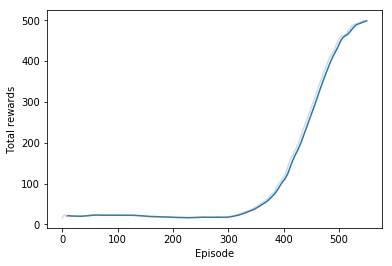

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

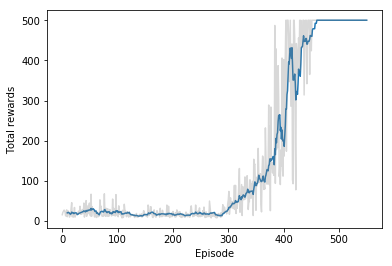

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

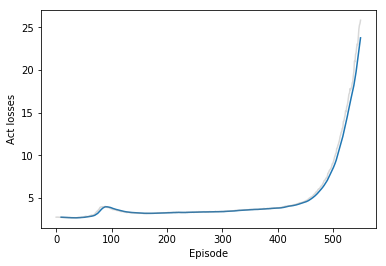

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

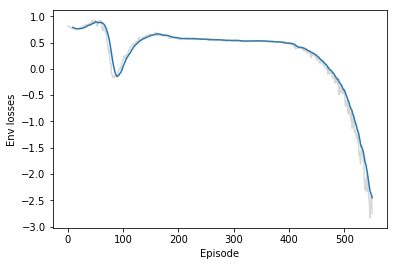

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
